# Differences in distance between initial-final positions between runs with and without tides, for GC+FES as well as GC+FES30

*Author: Miriam Sterl*

We plot the differences in (Haversine) distance between initial and final positions of particles that started at the same initial position, for the simulations with tides (GC+FES and GC+FES30) and the simulation without tides (GC).

In [1]:
from netCDF4 import Dataset
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

In [ ]:
File1 = '/science/projects/oceanparcels/output_data/data_Miriam/Results_TrackingGC.nc'
dataset1 = Dataset(File1)
lat1 = dataset1.variables['lat'][:]
lon1 = dataset1.variables['lon'][:]
time1 = dataset1.variables['time'][:]
dist1 = dataset1.variables['distance'][:]
lon1[lon1>180]-=360
lon1[lon1<-180]+=360

File2 = '/science/projects/oceanparcels/output_data/data_Miriam/Results_TrackingGCFES.nc'
dataset2 = Dataset(File2)
lat2 = dataset2.variables['lat'][:]
lon2 = dataset2.variables['lon'][:]
time2 = dataset2.variables['time'][:]
dist2 = dataset2.variables['distance'][:]
lon2[lon2>180]-=360
lon2[lon2<-180]+=360

File3 = '/science/projects/oceanparcels/output_data/data_Miriam/Results_TrackingGCFES30.nc'
dataset3 = Dataset(File3)
lat3 = dataset3.variables['lat'][:]
lon3 = dataset3.variables['lon'][:]
time3 = dataset3.variables['time'][:]
dist3 = dataset3.variables['distance'][:]
lon3[lon3>180]-=360
lon3[lon3<-180]+=360

In [3]:
def Haversine(lat1, lon1, lat2, lon2):
    """
    Haversine formula: determines the great-circle distance in km between two points on the (spherical) Earth given in lon/lat
    Formula from http://www.faqs.org/faqs/geography/infosystems-faq/ or more specifically,
    from R.W. Sinnott, "Virtues of the Haversine", Sky and Telescope, vol. 68, no. 2, 1984, p. 159
    """
    deg2rad = math.pi / 180.0
    R = 6371 # Earth radius in km
    dlat = (lat2 - lat1) * deg2rad # latitudinal distance in radians
    dlon = (lon2 - lon1) * deg2rad # longitudinal distance in radians
    h = (math.sin(dlat/2))**2 + math.cos(lat1 * deg2rad) * math.cos(lat2 * deg2rad) * (math.sin(dlon/2))**2
    d = 2 * R * math.asin(min(1,math.sqrt(h))) # min of 1 and sqrt(h) to protect from roundoff errors for antipodal points
    return d

In [4]:
havdist1 = np.zeros(lon1.shape[0]) # GC run
havdist2 = np.zeros(lon1.shape[0]) # GC+FES run
havdist3 = np.zeros(lon1.shape[0]) # GC+FES30 run

for i in range(lon1.shape[0]):
    havdist1[i] = Haversine(lat1[i,0], lon1[i,0], lat1[i,-1], lon1[i,-1]) # Haversine distance in GC run
    havdist2[i] = Haversine(lat2[i,0], lon2[i,0], lat2[i,-1], lon2[i,-1]) # Haversine distance in GC+FES run
    havdist3[i] = Haversine(lat3[i,0], lon3[i,0], lat3[i,-1], lon3[i,-1]) # Haversine distance in GC+FES30 run

# Difference in Haversine distance between GC+FES and GC run
havdistDiff_GCFES = havdist2 - havdist1

# Difference in Haversine distance between GC+FES30 and GC run
havdistDiff_GCFES30 = havdist3 - havdist1

havdistDiff = [havdistDiff_GCFES, havdistDiff_GCFES30]

C:\Users\miria\Anaconda3\envs\py2_parcels_M\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
# Initial longitudes and latitudes (on 2002-01-01)
startLons = lon1[:,0] # the initial longitudes on 2002-01-01
startLats = lat1[:,0] # the initial latitudes on 2002-01-01

titles = ['(a) Tides for 13 years', '(b) Tides for 30 days']

In [6]:
def HaversineDistancePlot(lons, lats, dist, fig, ax, vmax, titles, titlenr, titlesize, labelsize, colormap):
    """
    Function that plots the Haversine distance between a particle's initial and final position as a function of initial position
    """  
    minLat = np.min(np.round(lats)) # the minimal (rounded) latitude
    maxLat = np.max(np.round(lats)) # the maximal (rounded) latitude
    minLon = np.min(np.round(lons)) # the minimal (rounded) longitude
    maxLon = np.max(np.round(lons)) # the maximal (rounded) longitude

    allLats = np.arange(minLat, maxLat+1) # the latitudinal grid
    allLons = np.arange(minLon, maxLon+1) # the longitudinal grid
    
    havdists = np.zeros((len(allLons), len(allLats)))
    for i in range(len(dist)):
        havdists[int(np.round(lons[i]-minLon)), int(np.round(lats[i]-minLat))] = dist[i]
            # shift by minLon, minLat to get positive indices
    maskedDist = np.ma.masked_where(havdists==0.0, havdists) # mask land points
    
    Lat, Lon = np.meshgrid(allLats, allLons)
    havdistplot = ax.pcolormesh(Lon, Lat, maskedDist/1e3, cmap = colormap, vmin=-vmax, vmax=vmax)
    ax.set_title(titles[titlenr], fontsize=titlesize,fontweight='bold')
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor=(0.6,0.6,0.6))
    ax.set_xticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
    ax.set_xticklabels([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], fontsize=labelsize)
    ax.set_yticks([-90, -60, - 30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-90, -60, - 30, 0, 30, 60, 90], fontsize=labelsize)
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', alpha=0.25, linestyle=':')
    
    return havdistplot

C:\Users\miria\Anaconda3\envs\py2_parcels_M\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


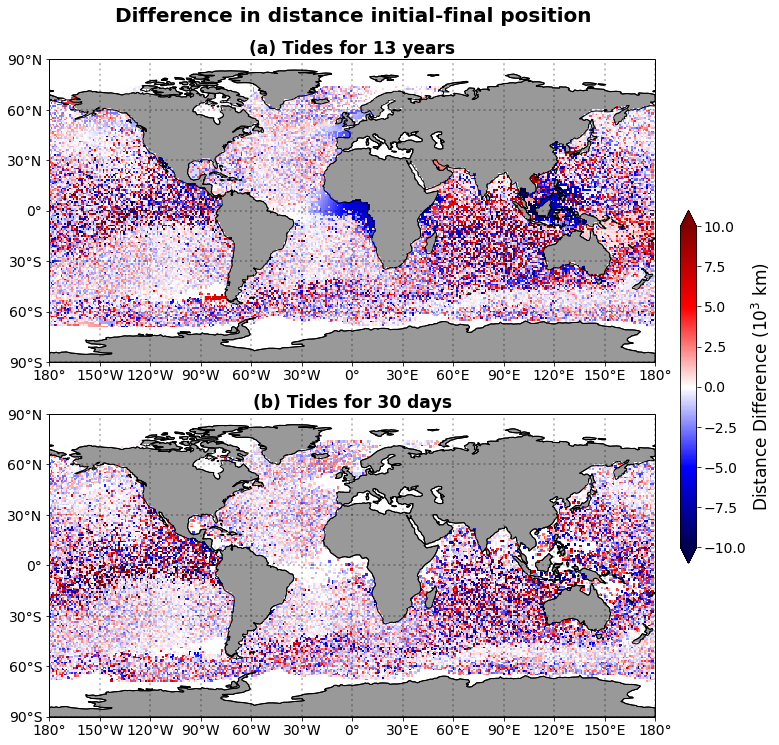

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14,10), subplot_kw={'projection': ccrs.PlateCarree()})
t = 17
l = 14
i = 0
for ax in axes.flat:
    havdistdiffplot = HaversineDistancePlot(startLons, startLats, havdistDiff[i], fig, ax, vmax=10, 
                         titles = titles, titlenr = i, titlesize=t, labelsize=l, colormap='seismic')
    i = i+1
cbar = fig.colorbar(havdistdiffplot, ax=axes.ravel().tolist(), shrink=0.65, extend='both', anchor=(2.3,0.5))
cbar.set_label("Distance Difference ($10^{3}$ km)", rotation=90, fontsize=t)
cbar.ax.tick_params(labelsize=l)
fig.suptitle('Difference in distance initial-final position', x=0.69, y=1.03, fontsize=20, fontweight='bold')
plt.tight_layout()
#plt.savefig('DistanceHaversineDifferences', bbox_inches='tight')